# Введение в обучение с подкреплением  (Reinforcement Learning)


<center>
<img src="https://raw.githubusercontent.com/jcformanek/jcformanek.github.io/master/docs/assets/images/rl_in_space.png" width="100%" />
</center>



**Введение**

На этом семинаре мы изучим обучение с подкреплением - тип машинного обучения без учителя, где агент учится выбирать действия, которые приводят к максимальному вознаграждению в долгосрочной перспективе. Обучение с подкреплением используется в широком спектре сложных задач, в том числе - в видеоиграх, например, [Atari](https://www.deepmind.com/blog/agent57-outperforming-the-human-atari-benchmark), [StarCraft II](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii) и [Dota II](https://openai.com/five/).

На семинаре изучим классическую среду - [CartPole](https://www.gymlibrary.ml/environments/classic_control/cart_pole/), где агент должен научиться балансировать шестом на тележке (см лекцию), используя несколько различных подходов RL. По пути вы познакомитесь с некоторыми из самых важных концепций и терминологии в RL.

**Темы:**
* Reinforcement Learning (RL, Обучение с подкреплением)
* Random Policy Search (Случайный поиск политики)
* Policy Gradient (Градиент политики)
* Q-Learning


**Что надо сделать для лучшего понимания:**

* почитать про библиотеку [JAX](https://github.com/google/jax).
* вспомнить нейроки.



### Настраиваем среду

In [1]:
# @title Установка необходимых пакетов (надо просто запустить!) { display-mode: "form" }
# @markdown Может занять несколько минут
%%capture
!pip install jaxlib
!pip install jax
!pip install git+https://github.com/deepmind/dm-haiku
!pip install gym==0.25
!pip install gym[box2d]
!pip install optax
!pip install matplotlib
!pip install chex
!pip install gym[classic_control]

In [2]:
# @title Импорт необходимых пакетов (просто запустите ячейку) { display-mode: "form" }
%%capture
import copy
from shutil import rmtree # deleting directories
import random
import collections # useful data structures
import numpy as np
import gym # reinforcement learning environments
from gym.wrappers import RecordVideo
import jax
import jax.numpy as jnp # jax numpy
import haiku as hk # jax neural network library
import optax # jax optimizer library
import matplotlib.pyplot as plt # graph plotting library
from IPython.display import HTML
from base64 import b64encode
import chex

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Ключевые концепции обучения с подкреплением

Обучение с подкреплением (RL) является подразделом машинного обучения (ML). В отличие от таких областей, как контролируемое обучение, где мы даем примеры ожидаемого поведения нашим моделям, RL фокусируется на *целеориентированном* обучении из взаимодействий методом проб и ошибок. Алгоритмы RL изучают, что делать (т. е. какие оптимальные действия предпринять) в среде, чтобы максимизировать некий сигнал вознаграждения. В таких условиях, как видеоигра, сигналом вознаграждения может быть счет игры, т. е. алгоритмы RL будут пытаться максимизировать счет в игре, выбирая лучшие действия.

<center>
<img src="https://pettingzoo.farama.org/_images/environments-demo.gif" width="40%" />
</center>

[*Image Source*](https://pettingzoo.farama.org/)

Другими словами, в RL у нас есть **агент**, который воспринимает **наблюдение** $o_t$ текущего состояния $s_t$ **окружающей среды** и должен выбрать **действие** $a_t$ для выполнения.

Затем окружающая среда переходит в новое состояние $s_{t+1}$ в ответ на действие агента, а также дает агенту скалярное вознаграждение $r_t$, чтобы указать, насколько хорошим или плохим было выбранное действие, учитывая состояние окружающей среды.

Целью в RL является максимизация агентом суммы вознаграждения, которое он получает от окружающей среды с течением времени. Нижний индекс $t$ используется для указания номера временного шага, т. е. $s_0$ - это состояние окружающей среды на начальном временном шаге, а $a_{99}$ - это действие агента на $99-м$ временном шаге.

### Среда - OpenAI Gym
Как упоминалось выше, среда получает от агента действие $a_t$ и возвращает вознаграждение $r_t$ и наблюдение $o_t$.

OpenAI разработал пакет для Python под названием **Gym**, который включает реализации популярных сред и простой интерфейс для взаимодействия агента RL. Чтобы использовать поддерживаемую [среду gym](https://www.gymlibrary.ml/), все, что вам нужно сделать, это передать имя среды в функцию  `gym.make(<environment_name>)`.

В этом уроке мы будем использовать простую среду под названием **CartPole**. В CartPole задача агента — научиться балансировать на шесте как можно дольше, перемещая тележку *влево* или *вправо*.

<img src="https://user-images.githubusercontent.com/10854026/32486103-f15f19de-c3a5-11e7-81de-0605df939497.gif" width="50%" />

In [3]:
# Create the environment
env_name = "CartPole-v0"
env = gym.make(env_name)

### Состояние (States) и Наблюдение (Observations) - $s_t$ and $o_t$

В RL агент воспринимает наблюдение за состоянием среды. В некоторых настройках наблюдение может включать всю информацию, лежащую в основе состояния среды. Такая среда называется **полностью наблюдаемой**. В других настройках агент может получать только частичную информацию о состоянии среды в своем наблюдении. Такая среда называется **частично наблюдаемой**.

В оставшейся части этого руководства мы будем предполагать, что среда полностью наблюдаема, и поэтому будем использовать состояние $s_t$ и наблюдение $o_t$ взаимозаменяемо. В Gym мы получаем начальное наблюдение из среды, вызывая функцию `env.reset()`.

In [4]:
# Reset the environment
s_0 = env.reset()
print("Initial State::", s_0)

# Get environment obs space
obs_shape = env.observation_space.shape
print("Environment Obs Space Shape:", obs_shape)

Initial State:: [-0.00546905 -0.04690116  0.02531915 -0.02184463]
Environment Obs Space Shape: (4,)


В CartPole состояние окружающей среды представлено четырьмя числами: *угловое положение полюса, угловая скорость полюса, положение тележки, скорость тележки*.

### Действия (Actions) - $a_t$

В RL действия обычно либо **дискретные**, либо **непрерывные**. Непрерывные действия задаются вектором действительных чисел. Дискретные действия задаются целочисленным значением. В средах, где мы можем подсчитать конечный набор действий, мы обычно используем дискретные действия.

В CartPole есть только два действия: *влево* и *вправо*. Таким образом, действия могут быть представлены целыми числами $0$ и $1$. В gym мы можем легко получить список возможных действий следующим образом:

In [5]:
# Get action space - e.g. discrete or continuous
print(f"Environment action space: {env.action_space}")

# Get num actions
num_actions = env.action_space.n
print(f"Number of actions: {num_actions}")

Environment action space: Discrete(2)
Number of actions: 2


### Политика агента (The Agent's Policy) - $\pi$

В RL агент выбирает действия на основе полученных наблюдений. Мы можем представить процесс выбора действия агента как функцию, которая принимает наблюдение в качестве входных данных и возвращает действие в качестве выходных данных. В RL мы обычно называем эту функцию **политикой** агента и обозначаем ее $\pi(s_t)=a_t$. В RL мы обычно параметризуем нашу политику каким-либо образом, а затем пытаемся узнать оптимальные параметры. Параметризованная политика обычно обозначается $\pi_\theta$, где $\theta$ — это набор параметров.

**Упражнение 1:** В качестве упражнения давайте реализуем простую политику, которая принимает набор параметров и наблюдение в качестве входных данных и возвращает действие. Предположим, что наблюдение — это вектор из четырех чисел, как наблюдение CartPole, и что действие должно быть либо $0$, либо $1$. Предположим также, что параметры — это вектор из четырех действительных чисел. Тогда действие должно быть вычислено следующим образом.


1. Вычислите [скалярное произведение векторов](https://www.mathsisfun.com/algebra/vectors-dot-product.html) между наблюдением и параметрами.
2. Если результат больше нуля, верните действие $1$.
3. В противном случае верните действие $0$.

В этом упражнении мы постараемся использовать JAX как можно чаще. Поэтому постарайтесь использовать методы JAX для этой задачи. Ниже приведены некоторые полезные методы, которые вы можете использовать. Вам нужно будет завершить код в блоке ниже, заменив `...` правильным кодом.


**Полезные методы:**
* Вычислите скалярное произведение векторов с помощью `jax.numpy.dot` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.dot.html)).

* Когда вы пытаетесь условно присвоить значение $0$ или $1$ действию на основе результата скалярного произведения, вам следует использовать `jax.lax.select` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.select.html#jax.lax.select)).

Метод `jax.lax.select` принимает три аргумента в качестве входных данных. Первый аргумент — это оператор, который будет оцениваться как `True` или `False`.

Если оператор равен `True`, то `jax.lax.select` вернет свой второй аргумент.

Если оператор имеет значение `False`, `jax.lax.select` вернет свой третий аргумент.



In [6]:
def linear_policy(params, obs):
  """A simple linear policy

  Args:
    params: a vector of four real-numbers that give the parameters of the policy
    obs: a vector of four real-numbers that give the agent's observation

  Returns:
    a discrete action given by a 0 or 1
  """
  # YOUR CODE
  dot_product_result = jax.numpy.dot(params, obs)

  action = jax.lax.select(
      dot_product_result > 0, # boolean statement goes here
      1, # result when the statement is True goes here
      0, # result when the statement is False goes here
  )
  # END YOUR CODE
  return action

In [7]:
# @title Проверка упр 1  { display-mode: "form" }

def check_linear_policy(linear_policy):
  fixed_obs = jnp.array([1,1,2,4])

  # check case1 - negative dot product.
  # weights
  params1 = jnp.array([1,1,1,1])
  params2 = jnp.array([-1,-1,-1,-1])

  hint1 = f"Неправильный ответ, ваша линейная политика неверна. Действие при \
obs={fixed_obs} и params={params1} должно быть 1"

  hint2 = f"Неправильный ответ, ваша линейная политика неверна. Действие при \
obs={fixed_obs} и params={params2} должно быть 0"

  hint = None
  if linear_policy(params1, fixed_obs) != 1:
    hint = hint1
  elif linear_policy(params2, fixed_obs) != 0:
    hint = hint2

  if hint is not None:
    print(hint)
  else:
    print("Your function is correct!")

try:
  check_linear_policy(linear_policy)
except Exception as e:
    print("An Error Occured: {}".format(e))

Your function is correct!


### Функция перехода среды - $P$

Теперь, когда у нас есть политика, мы можем передавать действия от агента среде. Затем среда перейдет в новое состояние в ответ на действие агента.

В RL мы моделируем этот процесс с помощью **функции перехода состояния** $P$, которая принимает текущее состояние $s_t$ и действие $a_t$ в качестве входных данных и возвращает следующее состояние $s_{t+1}$ в качестве выходных данных:

<center>
$s_{t+1}=P(s_t, a_t)$
</center>

В gym мы можем передавать действия среде, вызывая функцию `env.step(<action>)`. Затем функция вернет четыре значения:
- **следующее наблюдение**
- **награду** за выполненное действие
- логический флаг, указывающий, **завершена** игра
- некоторую **дополнительную** информацию.

In [8]:
# Get the initial obs by resetting the env
initial_obs = env.reset()

# Randomly sample actions from env
action = env.action_space.sample()

# Step the environment
next_obs, reward, done, info = env.step(action)

print("Observation:", initial_obs)
print("Action:", action)
print("Next observation:", next_obs)
print("Reward:", reward)
print("Game is done:", done)

Observation: [ 1.8787203e-02 -9.2136520e-07 -4.0286565e-03  2.4134295e-02]
Action: 0
Next observation: [ 0.01878718 -0.19506487 -0.00354597  0.3155434 ]
Reward: 1.0
Game is done: False


### Возврат эпизода - $R_t$

В RL мы обычно разбиваем взаимодействие агента с окружающей средой на **эпизоды**. Сумма всех вознаграждений, собранных во время эпизода, - это то, что мы называем **возвратом** эпизода - $R_t$:

<center>
$R_t=\sum_{t=0}^Tr_t$,
</center>

где $r_t$ - это вознаграждение в момент времени $t$, а $T$ - это последний временной шаг. Цель в RL - выбрать действия, которые максимизируют этот ожидаемый будущий возврат $R_t$.

### Цикл агент-среда
Теперь, когда мы знаем, что такое политика, и знаем, как пошагово проходить среду, давайте закроем цикл агент-среда.

**Упражнение 2:** Напишите функцию, которая запускает один эпизод CartPole, последовательно выбирая действия и пошагово проходя среду. Вам следует использовать линейную политику, которую мы определили ранее, для выбора действий. Функция должна отслеживать полученное вознаграждение и выводить возврат в конце эпизода.

В CartPole агент получает вознаграждение `1` за каждый временной шаг, когда шест все еще стоит вертикально. Если шест падает, игра заканчивается, и агент больше не получает вознаграждения. Игра также заканчивается после `200` временных шагов, поэтому максимальное вознаграждение, которое может получить агент, составляет `200`.

In [9]:
def run_episode(env):
  episode_return = 0 # counter to keep track of rewards
  done = False # initially set to False
  params = jnp.array([1,-2,2,-1]) # fixed policy parameters

  ## YOUR CODE

  obs = env.reset() # TODO: get the initial obs from the env

  while not done: # loop until episode is done

    action = linear_policy(params, obs) # TODO: compute action using linear policy
    action = np.array(action) # We need to the convert the action from the policy to a np.array

    obs, reward, done, info = env.step(action) # TODO: step the environment

    episode_return += reward # TODO: add reward to episode return

  return episode_return

In [10]:
# @title Проверка упр 2 (run me) { display-mode: "form" }

try:
  env.seed(42)
  if run_episode(env) == 31:
    print("Looks correct!")
  else:
    print("Looks like your implementation might be wrong.")
except Exception as e:
    print("An Error Occured: {}".format(e))

Looks correct!


В CartPole среда считается решенной, когда агент может надежно достичь возврата эпизода 500. Как вы можете видеть, наша текущая политика далека от оптимальной.

Один из способов найти оптимальную политику — это случайным образом пробовать разные политики, пока не найдем оптимальную. Эта стратегия называется случайным поиском политики и может быть на удивление эффективной.

Прежде чем мы реализуем случайный поиск политики, давайте быстро рассмотрим общий цикл обучения RL, который мы будем использовать для реализации алгоритмов в оставшейся части этого руководства.

### Цикл обучения RL общего назначения
Мы реализовали для вас цикл обучения RL общего назначения. Цикл обучения принимает несколько аргументов в качестве входных данных, но три наиболее важных для понимания — это `agent_select_action_func`, `agent_learn_func` и `agent_memory`.

* `agent_select_action_func` — это функция, которую мы определяем и можем передать в цикл обучения. Функция принимает наблюдение и набор `agent_params` в качестве входных данных и должна возвращать действие.
* `agent_learn_func` — это еще один метод, который мы определяем и передаем в цикл обучения. Он должен принимать параметры агента и некоторые «воспоминания» в качестве входных данных, а затем обновлять и возвращать агентам новые параметры.
* `agent_memory` — это модуль общего назначения, который мы определяем, который может хранить некоторую релевантную информацию об опыте агента в среде, которую можно использовать в `agent_learn_func`.

Ниже приведена функция цикла обучения, которую мы реализовали для вас. Вы можете просмотреть код и попытаться понять его, но это не обязательно. Таким образом, мы скрыли код по умолчанию, просто убедитесь, что вы запустили ячейку кода, прежде чем двигаться дальше, потому что цикл обучения далее в коде.

In [11]:
#@title Training loop (run me) { display-mode: "form" }

# NamedTuple to store transitions
Transition = collections.namedtuple("Transition", ["obs", "action", "reward", "next_obs", "done"])

# Training Loop
def run_training_loop(env_name, agent_params, agent_select_action_func,
    agent_actor_state=None, agent_learn_func=None, agent_learner_state=None,
    agent_memory=None, num_episodes=1000, evaluator_period=100,
    evaluation_episodes=8, learn_steps_per_episode=1,
    train_every_timestep=False, video_subdir="",):
    """
    This function runs several episodes in an environment and periodically does
    some agent learning and evaluation.

    Args:
        env: a gym environment.
        agent_params: an object to store parameters that the agent uses.
        agent_select_func: a function that does action selection for the agent.
        agent_actor_state (optional): an object that stores the internal state
            of the agents action selection function.
        agent_learn_func (optional): a function that does some learning for the
            agent by updating the agent parameters.
        agent_learn_state (optional): an object that stores the internal state
            of the agent learn function.
        agent_memory (optional): an object for storing an retrieving historical
            experience.
        num_episodes: how many episodes to run.
        evaluator_period: how often to run evaluation.
        evaluation_episodes: how many evaluation episodes to run.
        train_every_timestep: whether to train every timestep rather than at the end
            of the episode.
        video_subdir: subdirectory to store epsiode recordings.

    Returns:
        episode_returns: list of all the episode returns.
        evaluator_episode_returns: list of all the evaluator episode returns.
    """

    # Setup Cartpole environment and recorder
    env = gym.make(env_name, render_mode="rgb_array") # training environment
    eval_env = gym.make(env_name, render_mode="rgb_array") # evaluation environment

    # Video dir
    video_dir = "./video"+"/"+video_subdir

    # Clear video dir
    try:
      rmtree(video_dir)
    except:
      pass

    # Wrap in recorder
    env = RecordVideo(env, video_dir+"/train", episode_trigger=lambda x: (x % evaluator_period) == 0)
    eval_env = RecordVideo(eval_env, video_dir+"/eval", episode_trigger=lambda x: (x % evaluation_episodes) == 0)

    # JAX random number generator
    rng = hk.PRNGSequence(jax.random.PRNGKey(0))
    env.seed(0) # seed environment for reproducability
    random.seed(0)

    episode_returns = [] # List to store history of episode returns.
    evaluator_episode_returns = [] # List to store history of evaluator returns.
    timesteps = 0
    for episode in range(num_episodes):

        # Reset environment.
        obs = env.reset()
        episode_return = 0
        done = False

        while not done:

            # Agent select action.
            action, agent_actor_state = agent_select_action_func(
                                            next(rng),
                                            agent_params,
                                            agent_actor_state,
                                            np.array(obs)
                                        )

            # Step environment.
            next_obs, reward, done, _ = env.step(int(action))

            # Pack into transition.
            transition = Transition(obs, action, reward, next_obs, done)

            # Add transition to memory.
            if agent_memory: # check if agent has memory
              agent_memory.push(transition)

            # Add reward to episode return.
            episode_return += reward

            # Set obs to next obs before next environment step. CRITICAL!!!
            obs = next_obs

            # Increment timestep counter
            timesteps += 1

            # Maybe learn every timestep
            if train_every_timestep and (timesteps % 4 == 0) and agent_memory and agent_memory.is_ready(): # Make sure memory is ready
                # First sample memory and then pass the result to the learn function
                memory = agent_memory.sample()
                agent_params, agent_learner_state = agent_learn_func(
                                                        next(rng),
                                                        agent_params,
                                                        agent_learner_state,
                                                        memory
                                                    )

        episode_returns.append(episode_return)

        # At the end of every episode we do a learn step.
        if agent_memory and agent_memory.is_ready(): # Make sure memory is ready

            for _ in range(learn_steps_per_episode):
                # First sample memory and then pass the result to the learn function
                memory = agent_memory.sample()
                agent_params, agent_learner_state = agent_learn_func(
                                                        next(rng),
                                                        agent_params,
                                                        agent_learner_state,
                                                        memory
                                                    )

        if (episode % evaluator_period) == 0: # Do evaluation

            evaluator_episode_return = 0
            for eval_episode in range(evaluation_episodes):
                obs = eval_env.reset()
                done = False
                while not done:
                    action, _ = agent_select_action_func(
                                    next(rng),
                                    agent_params,
                                    agent_actor_state,
                                    np.array(obs),
                                    evaluation=True
                                )

                    obs, reward, done, _ = eval_env.step(int(action))

                    evaluator_episode_return += reward

            evaluator_episode_return /= evaluation_episodes

            evaluator_episode_returns.append(evaluator_episode_return)

            logs = [
                    f"Episode: {episode}",
                    f"Episode Return: {episode_return}",
                    f"Average Episode Return: {np.mean(episode_returns[-20:])}",
                    f"Evaluator Episode Return: {evaluator_episode_return}"
            ]

            print(*logs, sep="\t") # Print the logs

    env.close()
    eval_env.close()

    return episode_returns, evaluator_episode_returns

##2. Случайный поиск политики (RPS)
В разделе 1 мы использовали фиксированный набор параметров для нашей политики. То есть мы не изучали параметры $\pi$ $\theta$, мы просто сохранили их фиксированными ( `params = [1,-2,2,-1]`).

Теперь мы реализуем случайный поиск политики (RPS), который представляет собой алгоритм, который случайным образом пробует различные параметры политики и отслеживает лучшие параметры, найденные на данный момент. Мы скажем, что параметры политики $\theta_A$ лучше параметров $\theta_B$, если средний возврат эпизода, достигнутый за последние 20 эпизодов политикой с параметрами $\theta_A$, больше, чем у политики с параметрами $\theta_B$.

Чтобы отслеживать «текущие» параметры, а также «лучшие» параметры, мы будем использовать [NamedTuple](https://www.geeksforgeeks.org/namedtuple-in-python/).

In [12]:
# Parameter container for Random Policy Search
RandomPolicySearchParams = collections.namedtuple("RandomPolicySearchParams", ["current", "best"])

# TEST: store two different sets of parameters
current_params = np.ones(obs_shape) * -1
best_params = np.zeros(obs_shape)
rps_params = RandomPolicySearchParams(current_params, best_params)

# How to access the best or current params.
print(f"Best params: {rps_params.best}")
print(f"Current params: {rps_params.current}")

Best params: [0. 0. 0. 0.]
Current params: [-1. -1. -1. -1.]


Далее мы реализуем следующее:
- **Функция выбора действия RPS** - определяет, как мы выбираем действия с учетом набора параметров.
- **Модуль памяти RPS** - определяет, какой опыт хранить из взаимодействий со средой.
- **Функция обучения RPS** - определяет, как мы обновляем и улучшаем параметры нашей политики.

### Функция выбора действия RPS
Давайте реализуем функцию с именем `random_policy_search_choose_action`, которую мы можем передать в цикл обучения. Функция должна принимать несколько аргументов, чтобы она могла хорошо взаимодействовать с нашим обобщенным циклом обучения, но вам нужно будет использовать только три из них - `params`, `obs` и `evaluation`.

- `params` - это экземпляр `RandomPolicySearchParams` с "current" и "best".
- `obs` - это последнее наблюдение из среды.
- `evaluation` - это логическое значение, которое указывает, следует ли нам использовать параметры "current" или "best". Когда `evaluation==True`, мы должны использовать параметры "best", в противном случае мы должны использовать параметры "current".

**Упражнение 3:** Реализуйте функцию `random_policy_search_choose_action`, как описано выше. Вам следует использовать метод `linear_policy`, который мы определили ранее. Вам также понадобится `jax.lax.select()` для условного возврата "лучшего" действия или "текущего" действия.

In [13]:
def random_policy_search_choose_action(
    key,
    params,
    actor_state,
    obs,
    evaluation=False
):
  """Random policy search select action method.

  Args:
    key: a random number (seed). Not used in this function.
    params: the agent's parameters. In this case an instance of `RandomPolicySearchParams`
    actor_state: some extra information about the actor. Not used in this function.
    obs: the latest observation.
    evaluation: a boolean indicating whether to use the best "parameters" or the "current" ones.

  Returns:
    The chosen action and the updated actor_state. In this function the actor_state is not updated.
  """

  # YOUR CODE

  best_action = linear_policy(params=params.best, obs=obs)

  current_action = linear_policy(params=params.current, obs=obs)

  action = jax.lax.select(
      evaluation ,
      best_action ,
      current_action
  )

  # END YOUR CODE

  return action, actor_state

In [14]:
# @title Проверка упр 3 (run me) {display-mode: "form"}

def check_random_policy_search_choose_action(choose_action):
  key = None # not used
  actor_state = None # not used

  # obs
  obs = np.ones(obs_shape)

  evaluation=False
  current_params = np.ones(obs_shape) * -1
  best_params = np.ones(obs_shape)
  rps_params = RandomPolicySearchParams(current_params, best_params)
  action, actor_state = choose_action(key,rps_params,actor_state,obs,evaluation)
  if action != 0:
    return False

  evaluation=True
  current_params = np.ones(obs_shape) * -1
  best_params = np.ones(obs_shape)
  rps_params = RandomPolicySearchParams(current_params, best_params)
  action, actor_state = choose_action(key,rps_params,actor_state,obs,evaluation)
  if action != 1:
    return False

  return True

try:
  if check_random_policy_search_choose_action(random_policy_search_choose_action):
    print("Your function looks correct.")
  else:
    print("Your function looks incorrect.")
except Exception as e:
    print("An Error Occured: {}".format(e))

Your function looks correct.


### Память агента RPS

Для алгоритма поиска случайной политики нам нужно будет отслеживать средний возврат эпизода для последних 50 эпизодов. Помните, что мы сказали, что «текущие» параметры будут считаться «лучшими» параметрами, если средний возврат эпизода при использовании этих параметров больше предыдущего лучшего среднего возврата эпизода.

Мы будем использовать интерфейс памяти общего назначения, который довольно прост. Модуль памяти должен иметь три метода. Первый — это функция `memory.push(<transition>)`, которая добавляет некоторую информацию о последнем переходе среды в память. Второй — это функция `memory.is_ready()`, которая проверяет, готова ли память к обучению. Наконец, функция `memory.sample()` должна возвращать последний набор воспоминаний, которые можно передать в `agent_learn_func`.

#### Память среднего возврата эпизода
Мы создали для вас простой модуль памяти агента. Он хранит `epsisode_returns` последних 20 эпизодов. Прочитайте нашу реализацию ниже и посмотрите, сможете ли вы ее понять. Метод `memory.sample()` возвращает средний возврат эпизода за последние 20 эпизодов.

In [15]:
class AverageEpisodeReturnBuffer:

    def __init__(self, num_episodes_to_store=50):
        """
        This class implements an agent memory that stores the average episode
        return over the last 50 episodes.
        """
        self.num_episodes_to_store = num_episodes_to_store
        self.episode_return_buffer = []
        self.current_episode_return = 0

    def push(self, transition):
        self.current_episode_return += transition.reward

        if transition.done: # If the episode is done
            # Add episode return to buffer
            self.episode_return_buffer.append(self.current_episode_return)

            # Reset episode return
            self.current_episode_return = 0


    def is_ready(self):
        return len(self.episode_return_buffer) == self.num_episodes_to_store

    def sample(self):
        average_episode_return = np.mean(self.episode_return_buffer)

        # Clear episode return buffer
        self.episode_return_buffer = []

        return average_episode_return

### Функция обучения RPS
Наконец, нам нужно реализовать функцию `random_policy_search_learn` для нашего алгоритма поиска случайной политики. Функция обучения довольно проста. Все, что нам нужно сделать, это проверить, лучше ли текущие параметры, чем лучшие параметры. Если они лучше, то установите лучшие параметры в качестве текущих параметров и случайным образом сгенерируйте новый набор текущих параметров.

**Упражнение 4:** Напишите функцию для случайной генерации новых весов с использованием JAX. Веса должны быть выбраны из интервала `[-2,2]`.

**Полезные функции:**
*   `jax.random.uniform` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.uniform.html#jax.random.uniform))



In [16]:
def get_new_random_weights(random_key, old_weights, minval=-2.0, maxval=2.0):
    new_weights_shape = old_weights.shape # you will need to use these values
    new_weights_dtype = old_weights.dtype # you will need to use these values

    # YOUR CODE

    new_params = jax.random.uniform(dtype=new_weights_dtype, shape=new_weights_shape, minval=minval, maxval=maxval, key=random_key)

    # END YOUR CODE

    return new_params

In [17]:
# @title Проверка упр 4 (run me) {display-mode: "form"}

def check_get_new_random_weights(get_new_random_weights):
  old_weights = np.ones(obs_shape, "float32")
  random_key = jax.random.PRNGKey(42)

  # Case 1
  new_weights = get_new_random_weights(random_key, old_weights, minval=-2.0, maxval=2.0)

  if jnp.array_equal(new_weights, jnp.array([ 0.29657745,1.4265499, -1.7621555, -1.7505779 ])):
    print("Function is correct!")
  else:
    print("Something is wrong.")

try:
  check_get_new_random_weights(get_new_random_weights)
except Exception as e:
    print("An Error Occured: {}".format(e))

Function is correct!


Наша функция обучения получает память в форме среднего возврата эпизода из `AverageEpisodeReturnMemory`, которую мы реализовали ранее. Мы можем использовать это для сравнения текущих параметров с лучшими параметрами. Но нам также нужно будет отслеживать лучший средний возврат эпизода для функции обучения. Для этого мы можем использовать аргумент `learn_state`, который передается в `agent_learn_func` в нашем цикле обучения. Как и в случае с `RandomPolicySearchParams`, мы будем использовать NamedTuple для хранения `best_average_episode_return` в `learn_state`.

In [18]:
# A NamedTuple to store the best average episode return so far
RandomPolicyLearnState = collections.namedtuple(
  "RandomPolicyLearnState",
  ["best_average_episode_return"]
)

# Test
initial_learn_state = RandomPolicyLearnState(best_average_episode_return=-float("inf"))
print("Initial best average episode return:", initial_learn_state.best_average_episode_return)

Initial best average episode return: -inf


Теперь у нас есть все необходимое для реализации функции `random_policy_search_learn`.

**Упражнение 5:** Реализуйте функцию `random_policy_search_learn`. Функция должна проверять, лучше ли «текущие» параметры, чем «лучшие» параметры, сравнивая `current_average_episode_return` с `best_average_episode_return`. Функция также должна обновлять `learn_state`.

In [19]:
def random_policy_search_learn(key, params, learn_state, memory):
    best_params = params.best
    current_params = params.current

    current_average_episode_return = memory # the memory contains the average episode return
    best_average_episode_return = learn_state.best_average_episode_return


    # YOUR CODE

    best_params = jax.lax.select(
        best_params > current_params,
        best_params ,
        current_params
    )

    best_average_episode_return = jax.lax.select(
        best_average_episode_return > current_average_episode_return ,
        best_average_episode_return ,
        current_average_episode_return
    )

    # END YOUR CODE

    # Generate new random parameters
    new_params = get_new_random_weights(key, current_params)

    # Bundle weights in RandomPolicySearchParams NamedTuple
    params = RandomPolicySearchParams(current=new_params, best=best_params)

    return params, RandomPolicyLearnState(best_average_episode_return)

In [20]:
#@title Проверка упр 5 {display-mode: "form"}

params = RandomPolicySearchParams(np.ones(obs_shape, "float32"), np.ones(obs_shape, "float32") * -1)
learn_state = RandomPolicyLearnState(10)
memory = 11
key = jax.random.PRNGKey(42)

try:
  new_params, new_learn_state = random_policy_search_learn(key, params, learn_state, memory)

  if not jnp.array_equal(new_params.current, jnp.array([ 0.29657745,  1.4265499 , -1.7621555 , -1.7505779 ])):
    print("Your function is incorrect.")

  elif not jnp.array_equal(new_params.best, jnp.array([1., 1., 1., 1.])):
    print("Your function is incorrect.")

  elif new_learn_state.best_average_episode_return != 11:
    print("Your function is incorrect.")

  else:
    print("Your function looks correct.")
except Exception as e:
    print("An Error Occured: {}".format(e))

Your function looks correct.


### Цикл обучения RPS
Теперь мы можем собрать все вместе, передав модуль `memory`, функцию `learn` и функцию `choose_action` в цикл обучения. Чтобы ускорить наш алгоритм, мы будем использовать `jax.jit` в функции `learn` и функции `choose_action`.

Starting training. This may take up to 5 minutes to complete.
Episode: 0	Episode Return: 80.0	Average Episode Return: 80.0	Evaluator Episode Return: 126.5
Episode: 100	Episode Return: 55.0	Average Episode Return: 11.95	Evaluator Episode Return: 200.0
Episode: 200	Episode Return: 10.0	Average Episode Return: 8.85	Evaluator Episode Return: 200.0
Episode: 300	Episode Return: 102.0	Average Episode Return: 76.95	Evaluator Episode Return: 200.0
Episode: 400	Episode Return: 32.0	Average Episode Return: 10.6	Evaluator Episode Return: 193.5
Episode: 500	Episode Return: 10.0	Average Episode Return: 9.1	Evaluator Episode Return: 200.0
Episode: 600	Episode Return: 56.0	Average Episode Return: 11.8	Evaluator Episode Return: 196.625
Episode: 700	Episode Return: 52.0	Average Episode Return: 11.3	Evaluator Episode Return: 189.375
Episode: 800	Episode Return: 9.0	Average Episode Return: 27.6	Evaluator Episode Return: 191.25
Episode: 900	Episode Return: 9.0	Average Episode Return: 190.45	Evaluator Episo

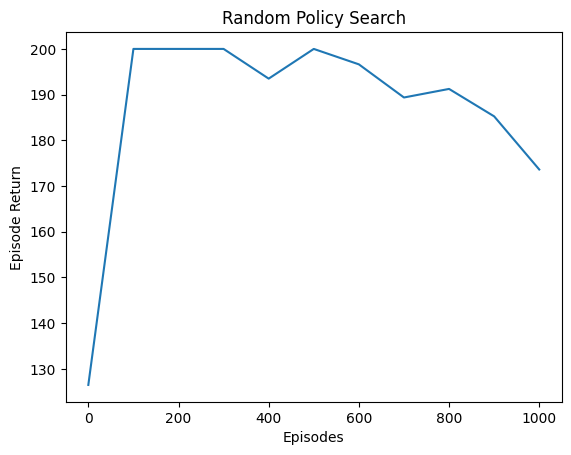

In [21]:
# JIT the learn and choose action functions
random_policy_search_learn_jit = jax.jit(random_policy_search_learn)
random_policy_search_choose_action_jit = jax.jit(random_policy_search_choose_action)

# Initialise the parameters
initial_weights = np.ones(obs_shape, "float32")
initial_params = RandomPolicySearchParams(initial_weights, initial_weights)

# Initialise the learn state
initial_learn_state = RandomPolicyLearnState(best_average_episode_return=-float("inf"))

# Initialise memory
memory = AverageEpisodeReturnBuffer(num_episodes_to_store=50)

# Run the training loop
print("Starting training. This may take up to 5 minutes to complete.")
chex.clear_trace_counter()
episode_return, evaluator_episode_returns = run_training_loop(
                                        env_name,
                                        initial_params,
                                        random_policy_search_choose_action_jit,
                                        None, # no actor state
                                        random_policy_search_learn_jit,
                                        initial_learn_state,
                                        memory,
                                        num_episodes=1001,
                                        video_subdir="rps"
                                    )

# Plot graph of evaluator episode returns
plt.plot(np.linspace(0, 1000, len(evaluator_episode_returns)), evaluator_episode_returns)
plt.title("Random Policy Search")
plt.xlabel("Episodes")
plt.ylabel("Episode Return")
plt.show()

Надеюсь, вы нашли набор оптимальных параметров на CartPole (возврат эпизода достигает `200`). В ячейке ниже вы можете посмотреть несколько видеороликов агента, выполняющего задание.

In [22]:
#@title Visualise Policy {display-mode: "form"}
#@markdown Choose an episode number that is a multiple of 100 and less than or equal to 2000, and **run** this cell.
episode_number = 1000 #@param {type:"number"}

assert (episode_number % 100) == 0, "Episode number must be a multiple of 100 since we only record every 100th episode."
assert episode_number < 1001, "Episode number must be less than or equal to 2000"

eval_episode_number = int(episode_number / 100 * 8)
video_path = f"./video/rps/eval/rl-video-episode-{eval_episode_number}.mp4"

mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Итак, случайный поиск политики справился с этой задачей довольно хорошо. Однако здесь происходит очень мало (если вообще происходит) реального *обучения*. Далее давайте рассмотрим реализацию простого алгоритма RL, который может использовать свой опыт для руководства нашим поиском оптимальной политики, а не просто искать ее случайным образом.

## 3. Градиенты политики  (Policy Gradients, PG)
Как обсуждалось, цель RL — найти политику, которая максимизирует ожидаемое совокупное вознаграждение (возврат), которое агент получает от среды. Мы можем записать ожидаемый возврат политики как:

$J(\pi_\theta)=\mathrm{E}_{\tau\sim\pi_\theta}\ [R(\tau)]$,

где $\pi_\theta$ — это политика, параметризованная $\theta$, $\mathrm{E}$ означает *ожидание*, $\tau$ — это сокращение для "*эпизод*", $\tau\sim\pi_\theta$ — это сокращение для "*эпизоды, выбранные с использованием политики* $\pi_\theta$", а $R(\tau)$ — это возврат эпизода $\tau$.

Затем, цель в RL — найти параметры $\theta$, которые максимизируют функцию $J(\pi_\theta)$. Один из способов найти эти параметры — выполнить градиентный подъем по $J(\pi_\theta)$ относительно параметров $\theta$:

$\theta_{k+1}=\theta_k + \alpha \nabla J(\pi_\theta)|_{\theta_{k}}$,

где $\nabla J(\pi_\theta)|_{\theta_{k}}$ — градиент ожидаемой доходности относительно параметров политики $\theta_k$, а $\alpha$ — размер шага. Эта величина, $\nabla J(\pi_\theta)$, также называется **градиентом политики** и очень важна в RL. Если мы сможем вычислить градиент политики, то у нас будет средство, с помощью которого можно напрямую оптимизировать нашу политику.

Как оказалось, у нас есть способ вычислить градиент политики, и математический вывод можно найти [здесь](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html). Но для этого руководства мы опустим вывод и просто дадим вам результат:

$\nabla_{\theta} J(\pi_{\theta})=\underset{\tau \sim \pi_{\theta}}{\mathrm{E}}[\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_{t} \mid s_{t}) R(\tau)]$

Неформально, градиент политики равен градиенту логарифма вероятности выбранного действия, умноженного на возврат эпизода, в котором было предпринято действие.


### REINFORCE
REINFORCE — это простой алгоритм RL, который использует градиент политики для поиска оптимальной политики путем увеличения вероятности выбора действий (усиливающих действий), которые, как правило, приводят к эпизодам с высокой отдачей.

**Упражнение 6:** Реализуйте функцию, которая берет вероятность действия и отдачу эпизода, в котором действие было предпринято, и вычисляет логарифм вероятности, умноженный на отдачу. Убедитесь, что вы используете JAX.

**Полезные функции:**
*   `jax.numpy.log`([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.log.html))

In [23]:
def compute_weighted_log_prob(action_prob, episode_return):

    # YOUR CODE

    log_porb = jax.numpy.log(action_prob)

    weighted_log_prob = log_porb * episode_return

    # END YOUR CODE

    return weighted_log_prob

In [24]:
#@title Проверка упр 6 {display-mode: "form"}

try:
  action_prob = 0.8
  episode_return = 100
  result = compute_weighted_log_prob(action_prob, episode_return)
  if result != -22.314354:
    print("Your implementation looks incorrect.")
  else:
    print("Looks correct.")
except Exception as e:
    print("An Error Occured: {}".format(e))

Looks correct.


### Rewards-to-go
Выполнение градиентного подъема по градиенту логарифма вероятности действия, взвешенного по возврату эпизода, будет иметь тенденцию повышать вероятность действий, которые были в эпизодах с высоким возвратом, независимо от того, *где* в эпизоде ​​было выполнено действие. Это на самом деле не имеет большого смысла, потому что действие ближе к концу эпизода может быть подкреплено, потому что много вознаграждения было собрано ранее в эпизоде, *до* того, как было выполнено действие. Агенты RL должны на самом деле подкреплять действия только на основе их *последствий*. Вознаграждения, полученные до выполнения действия, не влияют на то, насколько хорошим было это действие: только вознаграждения, которые приходят после. Накопленные вознаграждения, полученные после выполнения действия, называются **вознаграждениями-к-переходу** и могут быть вычислены как:

$\hat{R}_i=\sum_{t=i}^Tr_t$

Сравните это с доходностью эпизода:

$R(\tau)=\sum_{t=0}^Tr_t$

Мы можем повысить надежность градиента политики, заменив доходность эпизода на вознаграждения-к-переходу. Градиент политики с оставшимися наградами задается следующим образом:

$\nabla_{\theta} J(\pi_{\theta})=\underset{\tau \sim \pi_{\theta}}{\mathrm{E}}[\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_{t} \mid s_{t}) \hat{R}_t]$

**Упражнение 7:** Реализуйте функцию, которая берет список всех наград, полученных в эпизоде, и вычисляет оставшиеся награды. Не беспокойтесь об использовании JAX в этой функции. Вы можете использовать обычные операции Python, такие как `for-loops`.

In [38]:
def compute_rewards_to_go(rewards):
    """
    This function should take a list of rewards as input and
    compute the rewards-to-go for each timestep.

    EXAMPLE: compute_rewards_to_go([1,2,3,4]) = [10, 9, 7, 4]

    Arguments:
        rewards[t] is the reward at time step t.

    Returns:
        rewards_to_go[t] should be the reward-to-go at timestep t.
    """

    rewards_to_go = []

    # YOUR CODE
    residue = sum(rewards)
    rewards_to_go.append(residue)

    for i in range(0, len(rewards)-1):
      residue-=rewards[i]
      rewards_to_go.append(residue)

    # END YOUR CODE

    return rewards_to_go

In [39]:
#@title Проверка упр 7 {display-mode: "form"}

try:
  result = compute_rewards_to_go([1,2,3,4])

  if result != [10, 9, 7, 4]:
    print(result)
    print("There is a problem with your implementation.")
  else:
    print("Looks correct.")
except Exception as e:
    print("An Error Occured: {}".format(e))


Looks correct.


### REINFORCE memory
Далее нам нужно будет создать новую память агента для хранения вознаграждений $\hat{R}_t$ вместе с наблюдением $o_t$ и действием $a_t$ на каждом временном шаге. Ниже мы реализовали такой модуль памяти для вас. Функция `memory.sample()` вернет пакет из последних 500 воспоминаний. Вы можете прочитать код, чтобы попытаться понять его, но это не обязательно. Поэтому мы скрываем код по умолчанию.

In [40]:
# @title Реализация памяти (run me) {display-mode: "form"}

# NamedTuple to store memory
EpisodeRewardsToGoMemory = collections.namedtuple("EpisodeRewardsToGoMemory", ["obs", "action", "reward_to_go"])

class EpisodeRewardsToGoBuffer:

    def __init__(self, num_transitions_to_store=512, batch_size=256):
        self.batch_size = batch_size
        self.memory_buffer = collections.deque(maxlen=num_transitions_to_store)
        self.current_episode_transition_buffer = []

    def push(self, transition):
        self.current_episode_transition_buffer.append(transition)

        if transition.done:

            episode_rewards = []
            for t in self.current_episode_transition_buffer:
                episode_rewards.append(t.reward)

            r2g = compute_rewards_to_go(episode_rewards)

            for i, t in enumerate(self.current_episode_transition_buffer):
                memory = EpisodeRewardsToGoMemory(t.obs, t.action, r2g[i])
                self.memory_buffer.append(memory)

            # Reset episode buffer
            self.current_episode_transition_buffer = []


    def is_ready(self):
        return len(self.memory_buffer) >= self.batch_size

    def sample(self):
        random_memory_sample = random.sample(self.memory_buffer, self.batch_size)

        obs_batch, action_batch, reward_to_go_batch = zip(*random_memory_sample)

        return EpisodeRewardsToGoMemory(
            np.stack(obs_batch).astype("float32"),
            np.asarray(action_batch).astype("int32"),
            np.asarray(reward_to_go_batch).astype("int32")
        )


# Instantiate Memory
REINFORCE_memory = EpisodeRewardsToGoBuffer(num_transitions_to_store=512, batch_size=256)

### Policy neural network
Далее мы будем использовать простую нейронную сеть для аппроксимации политики. Наша нейронная сеть политики будет иметь входной слой, который принимает наблюдение в качестве входных данных и пропускает его через два скрытых слоя, а затем выводит одно скалярное значение для каждого из возможных действий. Таким образом, в CartPole выходной слой будет иметь размер `2`.

[Haiku](https://github.com/deepmind/dm-haiku) — это библиотека для реализации нейронных сетей в JAX. Ниже мы реализовали простую функцию для создания сети политики для вас.


In [41]:
def make_policy_network(num_actions: int, layers=[20, 20]) -> hk.Transformed:
  """Factory for a simple MLP network for the policy."""

  def policy_network(obs):
    network = hk.Sequential(
        [
            hk.Flatten(),
            hk.nets.MLP(layers + [num_actions])
        ]
    )
    return network(obs)

  return hk.without_apply_rng(hk.transform(policy_network))

У сетей Haiku есть две важные функции, о которых вам нужно знать. Первая — `network.init(<random_key>, <input>)`, которая возвращает набор случайных начальных параметров. Второй метод — `network.apply(<params>, <input>)`, который передает входные данные через сеть, используя предоставленный набор параметров.

In [42]:
# Example
POLICY_NETWORK = make_policy_network(num_actions=num_actions, layers=[20,20])
random_key = jax.random.PRNGKey(42) # random key
dummy_obs = np.ones(obs_shape, "float32")

# Initialise parameters
REINFORCE_params = POLICY_NETWORK.init(random_key, dummy_obs)
print("Initial params:", REINFORCE_params.keys())

# Pass input through the network
output = POLICY_NETWORK.apply(REINFORCE_params, dummy_obs)
print("Policy network output:", output)


Initial params: dict_keys(['mlp/~/linear_0', 'mlp/~/linear_1', 'mlp/~/linear_2'])
Policy network output: [ 0.91155875 -0.3961737 ]


Выходы нашей сети политик — [логиты](https://qr.ae/pv4YTe). Чтобы преобразовать это в распределение вероятностей по действиям, мы передаем логиты в функцию [softmax](https://en.wikipedia.org/wiki/Softmax_function).

### УСИЛЕНИЕ выбор функции действия

**Упражнение 8:** Завершите функцию ниже, которая берет вектор логитов и случайным образом выбирает действие из категориального распределения, заданного логитами.

**Полезные функции:**

In [43]:
def sample_action(random_key, logits):

  # YOUR CODE HERE
  action = jax.random.categorical(logits=logits, key=random_key)

  # END YOUR code

  return action

In [44]:
#@title Проверка упр 8 {display-mode: "form"}

try:
  random_key = jax.random.PRNGKey(42) # random key
  action = sample_action(random_key, np.array([1,2], "float32"))
  if action != 1:
    print("Your function is incorrect.")
  else:
    print("Seems correct.")
except Exception as e:
    print("An Error Occured: {}".format(e))

Seems correct.


Теперь мы можем реализовать функцию `REINFORCE_choose_action`. Мы передадим наблюдение через сеть политики для вычисления логитов, а затем передадим логиты в функцию `sample_action` для выбора и действия.

In [45]:
def REINFORCE_choose_action(key, params, actor_state, obs, evaluation=False):
  obs = jnp.expand_dims(obs, axis=0) # add dummy batch dim before passing through network

  # Pass obs through policy network to compute logits
  logits = POLICY_NETWORK.apply(params, obs)
  logits = logits[0] # remove batch dim

  # Randomly sample action
  sampled_action = sample_action(key, logits)

  return sampled_action, actor_state

Теперь, когда мы реализовали функцию `REINFORCE_choose_action`, нам осталось только создать функцию `REINFORCE_learn`. Функция обучения должна использовать функцию `weighted_log_prob`, которую мы создали ранее, чтобы вычислить потери градиента политики и применить обновления градиента к нашей нейронной сети.

### Policy gradient loss


**Упражнение 9:** Завершите функцию `policy_gradient_loss` ниже. Функция должна вычислять вероятности действий, пропуская `logits` через функцию softmax. Затем следует извлечь вероятность заданного `action` (используя индексацию массива) и вычислить `weighted_log_prob`, используя функцию, которую мы создали ранее.

**Полезные методы:**
*   `jax.nn.softmax` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.nn.softmax.html))

In [46]:
def policy_gradient_loss(action, logits, reward_to_go):

  # YOUR CODE

  all_action_probs = jax.nn.softmax(x=logits) # convert logits into probs

  action_prob = all_action_probs[action] # using array indexing to get prob of action

  weighted_log_prob = compute_weighted_log_prob(action_prob=action_prob, episode_return=reward_to_go)

  # END YOUR CODE

  loss = - weighted_log_prob # negative because we want gradient `ascent`

  return loss

In [49]:
#@title Проверка упр 9 {display-mode: "form"}

try:
  result = policy_gradient_loss(1, np.array([1,2], "float32"), 10)
  print(result)
  if result != 3.1326175:
    print("Your implementation looks wrong.")
  else:
    print("Looks correct.")
except Exception as e:
  print("An Error Occured: {}".format(e))


3.1326165
Your implementation looks wrong.


Когда мы делаем шаг обновления градиента политики, мы захотим сделать это, используя пакет опыта, а не просто один опыт, как выше. Мы можем использовать функцию JAX [vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html#jax.vmap), чтобы легко заставить нашу функцию `policy_gradient_loss` работать с пакетом опыта.

In [50]:
def batched_policy_gradient_loss(params, obs_batch, action_batch, reward_to_go_batch):
    # Get logits by passing observation through network
    logits_batch = POLICY_NETWORK.apply(params, obs_batch)

    policy_gradient_loss_batch = jax.vmap(policy_gradient_loss)(
        action_batch,
        logits_batch,
        reward_to_go_batch) # add batch

    # Compute mean loss over batch
    mean_policy_gradient_loss = jnp.mean(policy_gradient_loss_batch)

    return mean_policy_gradient_loss

# TEST
obs_batch = np.ones((3, *obs_shape), "float32")
actions_batch = np.array([1,0,0])
rew2go_batch = np.array([2.3, 4.3, 2.1])

loss = batched_policy_gradient_loss(REINFORCE_params, obs_batch, actions_batch, rew2go_batch)

print("Policy gradient loss on batch:", loss)

Policy gradient loss on batch: 1.6967314


### Оптимизатор сети

Чтобы применить обновления градиента политики к нашей нейронной сети, мы будем использовать библиотеку JAX под названием [Optax](https://github.com/deepmind/optax). Optax имеет реализацию [оптимизатора Adam](https://www.geeksforgeeks.org/intuition-of-adam-optimizer/), которую мы можем использовать.

In [51]:
REINFORCE_OPTIMIZER = optax.adam(1e-3)

# Initialise the optimiser
REINFORCE_optim_state = REINFORCE_OPTIMIZER.init(REINFORCE_params)

Теперь у нас есть все необходимое для создания функции `REINFORCE_learn`. Мы сохраним состояние оптимизатора в `learn_state`. Мы вычислим градиент потерь градиента политики с помощью  `jax.grad` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html)).

In [52]:
# A NamedTuple to store the state of the optimiser
REINFORCELearnState = collections.namedtuple("LearnerState", ["optim_state"])


def REINFORCE_learn(key, params, learner_state, memory):

  # Get the policy gradient by using `jax.grad()` on `batched_policy_gradient_loss`
  grad_loss = jax.grad(batched_policy_gradient_loss)(params, memory.obs, memory.action, memory.reward_to_go)

  # Get param updates using gradient and optimizer
  updates, new_optim_state = REINFORCE_OPTIMIZER.update(grad_loss, learner_state.optim_state)

  # Apply updates to params
  params = optax.apply_updates(params, updates)

  return params, REINFORCELearnState(new_optim_state) # update learner state

### Цикл обучения REINFORCE
Теперь мы можем обучить нашего агента REINFORCE, собрав все воедино с помощью цикла обучения.

Starting training. This may take up to 10 minutes to complete.
Episode: 0	Episode Return: 12.0	Average Episode Return: 12.0	Evaluator Episode Return: 16.625
Episode: 100	Episode Return: 52.0	Average Episode Return: 38.4	Evaluator Episode Return: 49.875
Episode: 200	Episode Return: 174.0	Average Episode Return: 139.0	Evaluator Episode Return: 151.75
Episode: 300	Episode Return: 144.0	Average Episode Return: 187.95	Evaluator Episode Return: 165.625
Episode: 400	Episode Return: 200.0	Average Episode Return: 194.05	Evaluator Episode Return: 194.5
Episode: 500	Episode Return: 169.0	Average Episode Return: 166.4	Evaluator Episode Return: 190.375
Episode: 600	Episode Return: 200.0	Average Episode Return: 198.5	Evaluator Episode Return: 200.0
Episode: 700	Episode Return: 200.0	Average Episode Return: 200.0	Evaluator Episode Return: 200.0
Episode: 800	Episode Return: 200.0	Average Episode Return: 200.0	Evaluator Episode Return: 200.0
Episode: 900	Episode Return: 200.0	Average Episode Return: 19

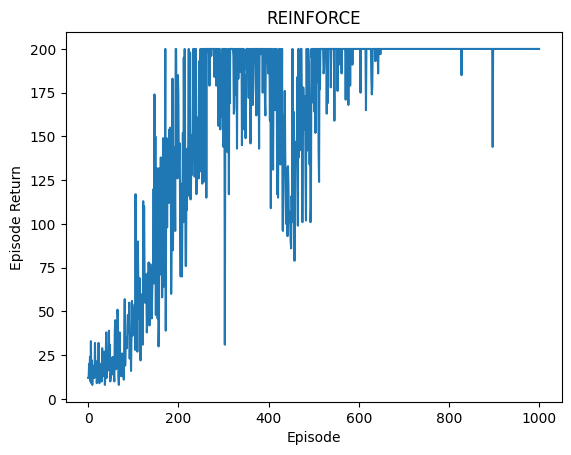

In [53]:
# JIT the choose_action and learn functions for more speed
REINFORCE_learn_jit = jax.jit(REINFORCE_learn)
REINFORCE_choose_action_jit = jax.jit(REINFORCE_choose_action)

# Initial learn state
REINFORCE_learn_state = REINFORCELearnState(REINFORCE_optim_state)

# Run training loop
print("Starting training. This may take up to 10 minutes to complete.")
episode_returns, evaluator_returns = run_training_loop(
                                        env_name,
                                        REINFORCE_params,
                                        REINFORCE_choose_action_jit,
                                        None, # action state not used
                                        REINFORCE_learn_jit,
                                        REINFORCE_learn_state,
                                        REINFORCE_memory,
                                        num_episodes=1001,
                                        learn_steps_per_episode=2,
                                        video_subdir="reinforce"
                                      )

# Plot the episode returns
plt.plot(episode_returns)
plt.xlabel("Episode")
plt.ylabel("Episode Return")
plt.title("REINFORCE")
plt.show()


In [55]:
#@title Визуализация {display-mode: "form"}
#@markdown Выберите номер эпизода, менее или равного 1000, и **run this cell**.

episode_number = 1000 #@param {type:"number"}

assert (episode_number % 100) == 0, "Episode number must be a multiple of 100 since we only record every 100th episode."
assert episode_number < 1001, "Episode number must be less than or equal to 1000"

eval_episode_number = int(episode_number / 100 * 8)
video_path = f"./video/reinforce/eval/rl-video-episode-{eval_episode_number}.mp4"

mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## 4. Q-Learning
Другим распространенным подходом к поиску оптимальной политики в среде с использованием RL является Q-обучение.

### Функция значения состояния-действия
В Q-обучении агент изучает функцию, которая аппроксимирует **значение** пар состояние-действие. Под *значением* мы подразумеваем отдачу, которую вы ожидаете получить, если начнете в определенном состоянии $s_t$, выполните определенное действие $a_t$, а затем будете действовать в соответствии с определенной политикой $\pi$ навсегда. Функция значения состояния-действия политики $\pi$ задается как

$Q_\pi(s,a)=\mathrm{E}_{\tau\sim\pi}\left[R(\tau) \mid s_0=s,\ a_t=a\right]$.

Мы говорим, что функция значения $Q_\pi(s,a)$ является **оптимальной** функцией значения, если политика $\pi$ является оптимальной политикой. Обозначим функцию оптимального значения следующим образом:

$Q_\ast(s,a)=\max \limits_\pi \ \mathrm{E}_{\tau\sim\pi}\left[R(\tau) \mid s_0=s,\ a_0=a\right]$

Существует важная связь между оптимальным действием $a_\ast$ в состоянии $s$ и оптимальной функцией значения состояния-действия $Q_\ast$. А именно, оптимальное действие $a_\ast$ в состоянии $s$ равно действию, которое максимизирует оптимальную функцию значения состояния-действия. Эта связь естественным образом индуцирует оптимальную политику:

$\pi_\ast(s)=\arg \max \limits_a\ Q_\ast(s, a)$

### Greedy action selection (Жадный выбор действия)

**Упражнение 10:** Давайте реализуем функцию, которая, учитывая вектор Q-значений, возвращает действие с наибольшим Q-значением (т. е. жадное действие).

**Useful methods:**
*   `jax.numpy.argmax` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.argmax.html))

In [57]:
# Implement a function takes q-values as input and returns the greedy_action
def select_greedy_action(q_values):

  # YOUR CODE
  action = jax.numpy.argmax(a=q_values)
  # END YOUR CODE

  return action

In [58]:
# @title Проверка упр 10 (run me) {display-mode: "form"}

try:
  q_values = jnp.array([1,1,3,4])
  action = select_greedy_action(q_values)

  if action != 3:
    print("Incorrect answer, your greedy action selector looks wrong")
  else:
    print("Looks good.")
except Exception as e:
  print("An Error Occured: {}".format(e))


Looks good.


### Q-Network
В отличие от подхода с градиентом политики из предыдущего раздела, в Q-обучении и других методах RL на основе значений нам не нужна параметризация для политики, вместо этого мы параметризуем Q-функцию с помощью нейронной сети $Q_\theta$. Мы получаем политику из Q-сети, всегда выбирая действие с *наибольшим* значением:

$\hat{\pi}_\theta(s)=\arg \max \limits_a\ Q_{\theta}(s, a)$

Как и ранее, мы будем использовать хайку для создания нейронной сети для аппроксимации этой Q-функции. Сеть будет принимать наблюдение в качестве входных данных, а затем выводить Q-значение для каждого из доступных действий. Таким образом, в случае CartPole выход сети будет иметь размер $2$.

In [59]:
def build_network(num_actions: int, layers=[20, 20]) -> hk.Transformed:
  """Factory for a simple MLP network for approximating Q-values."""

  def q_network(obs):
    network = hk.Sequential(
        [hk.Flatten(),
         hk.nets.MLP(layers + [num_actions])])
    return network(obs)

  return hk.without_apply_rng(hk.transform(q_network))

Давайте инициализируем нашу Q-сеть и получим начальные параметры.

In [60]:
# Initialise Q-network
Q_NETWORK = build_network(num_actions=num_actions, layers=[20, 20]) # two actions

dummy_obs = jnp.zeros((1,*obs_shape), jnp.float32) # a dummy observation like the one in CartPole

random_key = jax.random.PRNGKey(42) # random key
Q_NETWORK_PARAMS = Q_NETWORK.init(random_key, dummy_obs) # Get initial params

print("Q-Learning params:", Q_NETWORK_PARAMS.keys())

Q-Learning params: dict_keys(['mlp/~/linear_0', 'mlp/~/linear_1', 'mlp/~/linear_2'])


Прежде чем мы реализуем функцию потерь, необходимую для обучения нашей Q-сети, давайте сначала обсудим интуицию, стоящую за ней.

### The Bellman Equations (Уравнения Беллмана)
Функция значения может быть записана рекурсивно как:

$Q_{\pi}(s, a) =\underset{s^{\prime} \sim P}{\mathrm{E}}\left[r(s, a)+ \underset{a^{\prime} \sim \pi}{\mathrm{E}}\left[Q_{\pi}\left(s^{\prime}, a^{\prime}\right)\right]\right]$,

где $s' \sim P$ — это сокращение для обозначения того, что следующее состояние $s'$ выбирается из функции перехода среды $P(s'\mid s,a)$. Интуитивно это уравнение говорит, что ценность действия $a$, которое вы предприняли в состоянии $s$, равна вознаграждению $r$, которое вы ожидаете получить, плюс ценность, которую вы ожидаете получить в следующем состоянии $s`$, в котором вы окажетесь, при условии, что вы выберете свое следующее действие $a`$ с политикой $\pi$. Уравнение Беллмана для оптимальной функции ценности выглядит так:

$Q_{*}(s, a) =\underset{s^{\prime} \sim P}{\mathrm{E}}\left[r(s, a)+\ \underset{a^{\prime}}{\max}\ Q_{*}(s^{\prime}, a^{\prime})\right]$

Обратите внимание, что вместо выбора вашего следующего действия $a`$ с политикой $\pi$ мы выбираем действие с наибольшим значением Q.

Более подробное обсуждение уравнений Беллмана можно найти на сайте [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html).

### The Bellman Backup (Резервное копирование Беллмана)

Чтобы научиться аппроксимировать оптимальную функцию Q-значения, мы можем использовать правую часть уравнения Беллмана в качестве правила обновления. Другими словами, предположим, что у нас есть Q-сеть $Q_\theta$, аппроксимированная с использованием параметров $\theta$, тогда мы можем итеративно обновлять параметры таким образом, что

$Q_\theta(s,a)\leftarrow r(s, a) + \underset{a'}{\max}\ Q_\theta(s', a')$.

Интуитивно это означает, что аппроксимация Q-значения действия $a$ в состоянии $s$ должна быть обновлена ​​таким образом, чтобы она была ближе к равной вознаграждению, полученному от среды $r(s, a)$, плюс значение наилучшего возможного действия в следующем состоянии $s'$. Мы можем выполнить эту оптимизацию, минимизируя разницу между левой и правой частью относительно параметров $\theta$, используя градиентный спуск. Мы можем измерить разницу между двумя значениями, используя [квадратичную ошибку](https://en.wikipedia.org/wiki/Mean_squared_error#Loss_function).

**Упражнение 11:** Реализуйте функцию квадратичной ошибки.

**Полезные функции**
* `jax.numpy.square` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.square.html))

In [61]:
def compute_squared_error(pred, target):
  # YOUR CODE
  squared_error = jax.numpy.square(pred - target)
  # END YOUR CODE

  return squared_error

In [62]:
#@title Проверка упр 11 {display-mode: "form"}

try:
  result = compute_squared_error(1, 4)

  if result != 9:
    print("Your implementation looks wrong.")
  else:
    print("Looks good.")
except Exception as e:
  print("An Error Occured: {}".format(e))

Looks good.


**Упражнение 12:** Реализуйте функцию, которая вычисляет **цель Беллмана** (правая часть уравнения Беллмана). Если эпизод находится на последнем временном шаге (т. е. done==1.0), то цель Беллмана должна быть равна награде, без дополнительного значения в конце.

**Полезные функции**
* `jax.numpy.max` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.max.html))

In [64]:
# Bellman target
def compute_bellman_target(reward, done, next_q_values):
  """A function to compute the bellman target.

  Args:
      reward: a scalar reward.
      done: a scalar of value either 1.0 or 0.0, indicating if the transition is a terminal one.
      next_q_values: a vector of q_values for the next state. One for each action.
  Returns:
      A scalar equal to the bellman target.

  """
  # YOUR CODE
  bellman_target = reward + jax.numpy.max(a=next_q_values) * (1.0 - done)
  # END YOUR CODE

  return bellman_target

In [65]:
#@title Проверка упр 12 {display-mode: "form"}

try:
  # not done
  result1 = compute_bellman_target(1, 0.0, np.array([3,2], "float32"))

  # done
  result2 = compute_bellman_target(1, 1.0, np.array([3,2], "float32"))

  if result1 != 4 or result2 != 1:
    print("Your implementation looks wrong.")
  else:
    print("Looks good.")
except Exception as e:
  print("An Error Occured: {}".format(e))

Looks good.


Теперь мы можем объединить эти две функции, чтобы вычислить потерю для Q-обучения. Потери Q-обучения равны квадрату разницы между прогнозируемым значением Q действия и его соответствующей целью Беллмана.

**Упражнение 13:** Реализуйте функцию потери Q-обучения.

In [66]:
def q_learning_loss(q_values, action, reward, done, next_q_values):
    """Implementation of the Q-learning loss.T

    Args:
        q_values: a vector of Q-values, one for each action.
        action: an integer, giving the action that was chosen. q_values[action] is the value of the chose action.
        done: is a scalar that indicates if this is a terminal transition.
        next_q_values: a vector of Q-values in the next state.
    Returns:
        The squared difference between the q_value of the chosen action and the bellman target.
    """
    # YOUR CODE
    chosen_action_q_value = q_values[action] # q_value of action, use array indexing
    bellman_target = compute_bellman_target(done=done, next_q_values=next_q_values, reward=reward)
    squared_error = compute_squared_error(pred=chosen_action_q_value, target=bellman_target)
    # END YOUR CODE

    return squared_error

In [67]:
#@title Проверка упр 13 {display-mode: "form"}

try:
  result = q_learning_loss(np.array([3,2], "float32"), 1, 2, 0.0, np.array([3,2], "float32"))

  if result != 9.0:
    print("Your implementation looks wrong.")
  else:
    print("Looks good.")
except Exception as e:
  print("An Error Occured: {}".format(e))

Looks good.


### Target Q-network (Целевая Q-сеть)
Обратите внимание: когда мы вычисляем цель Беллмана, мы используем нашу Q-сеть $Q_\theta$ для вычисления значения для следующего состояния $s_t$. По сути, мы используем наше последнее приближение Q-функции для вычисления цели нашего следующего приближения. Использование приближения для вычисления цели для вашего следующего приближения называется самозагрузкой. К сожалению, если мы наивно делаем такую ​​самозагрузку, это может сделать обучение нейронной сети очень нестабильным. Чтобы смягчить это, мы можем вместо этого использовать другой набор параметров $\hat{\theta}$ для вычисления значений в состоянии $s_{t+1}$. Мы будем сохранять параметры $\hat{\theta}$ фиксированными и только периодически обновлять их, чтобы они были равны последним онлайн-параметрам $\theta$ каждые пару шагов обучения *(скажем, 100)*. Это позволяет сохранять фиксированные цели Беллмана для пары шагов обучения, чтобы помочь снизить нестабильность из-за самозагрузки.

Нам нужно будет отслеживать последние (онлайн) параметры, а также параметры целевых сетей. Давайте создадим `NamedTuple` для хранения этих двух значений. Нам также нужно будет отслеживать количество шагов обучения, которые мы сделали, чтобы знать, когда обновлять целевую сеть. Давайте сохраним `count` шагов обучения в `learn_state`.

In [68]:
# Store online and target parameters
QLearnParams = collections.namedtuple("Params", ["online", "target"])

# Q-learn-state
QLearnState = collections.namedtuple("LearnerState", ["count", "optim_state"])

Мы снова будем использовать Optax для оптимизации нашей нейронной сети в JAX. Мы сохраняем состояние оптимизатора в `learn_state` выше. Давайте теперь создадим экземпляр оптимизатора и добавим начальные параметры Q-сети в объект `QLearnParams`.

In [69]:
# Initialise Q-network optimizer
Q_LEARN_OPTIMIZER = optax.adam(3e-4) # learning rate

Q_LEARN_OPTIM_STATE = Q_LEARN_OPTIMIZER.init(Q_NETWORK_PARAMS) # initial optim state

# Create Learn State
Q_LEARNING_LEARN_STATE = QLearnState(0, Q_LEARN_OPTIM_STATE) # count set to zero initially

# Add initial Q-network weights to QLearnParams object
Q_LEARNING_PARAMS = QLearnParams(online=Q_NETWORK_PARAMS, target=Q_NETWORK_PARAMS) # target equal to online

Теперь мы можем реализовать простую функцию, которая обновляет параметры целевых сетей, чтобы они соответствовали последним онлайн-параметрам каждые 100 шагов обучения.

In [70]:
def update_target_params(learn_state, online_weights, target_weights):
  """A function to update target params every 100 training steps"""

  target = jax.lax.cond(
      jax.numpy.mod(learn_state.count, 100) == 0,
      lambda x, y: x,
      lambda x, y: y,
      online_weights,
      target_weights
  )

  params = QLearnParams(online_weights, target)

  return params

### Q-learning loss (Функция потери Q-обучения)
Теперь у нас есть все необходимое для реализации функции `q_learn`, которая принимает некоторую партию переходов и выполняет шаг Q-обучения для обновления параметров сети. Но сначала мы используем `jax.vmap` для изменения функции `q_learning_loss` так, чтобы она принимала партии переходов. Кроме того, мы вычислим Q-значения, передавая наблюдения через `Q_NETWORK`, и целевые Q-значения, используя целевые параметры `Q_NETWORK`.

In [71]:
def batched_q_learning_loss(online_params, target_params, obs, actions, rewards, next_obs, dones):
    q_values = Q_NETWORK.apply(online_params, obs) # use the online parameters
    next_q_values = Q_NETWORK.apply(target_params, next_obs) # use the target parameters
    squared_error = jax.vmap(q_learning_loss)(q_values, actions, rewards, dones, next_q_values) # vmap q_learning_loss
    mean_squared_error = jnp.mean(squared_error) # mean squared error over batch
    return mean_squared_error

Теперь мы можем создать функцию `q_learn`, которая вычисляет градиент `batched_q_learning_loss`, а затем использует оптимизатор Optax для обновления весов сети, а затем, наконец (возможно), обновляет целевые параметры.

In [72]:
def q_learn(rng, params, learner_state, memory):
  # Compute gradients
  grad_loss = jax.grad(batched_q_learning_loss)(params.online, params.target, memory.obs,
                                          memory.action, memory.reward,
                                          memory.next_obs, memory.done,
                                          ) # jax.grad

  # Get updates
  updates, opt_state = Q_LEARN_OPTIMIZER.update(grad_loss, learner_state.optim_state)

  # Apply them
  new_weights = optax.apply_updates(params.online, updates)

  # Maybe update target network
  params = update_target_params(learner_state, new_weights, params.target)

  # Increment learner step counter
  learner_state = QLearnState(learner_state.count + 1, opt_state)

  return params, learner_state

### Replay Buffer (Буфер воспроизведения)
Для Q-обучения нам понадобится память агента, которая хранит целые переходы: `obs`, `action`, `reward`, `next_obs`, `done`. Когда мы извлекаем переходы из памяти, они должны выбираться случайным образом из всех переходов, собранных до сих пор. В RL мы часто называем такой модуль **буфером воспроизведения**.

Одним из преимуществ использования такого буфера воспроизведения является то, что опыт можно повторно использовать несколько раз для обучения, в отличие от алгоритма градиента политики REINFORCE, где мы отбрасывали воспоминания после их использования для обучения.

In [73]:
class TransitionMemory(object):
  """A simple Python replay buffer."""

  def __init__(self, max_size=10_000, batch_size=256):
    self.batch_size = batch_size
    self.buffer = collections.deque(maxlen=max_size)

  def push(self, transition):

    # add transition to the replay buffer
    self.buffer.append(
        (transition.obs, transition.action, transition.reward,
          transition.next_obs, transition.done)
    )


  def is_ready(self):
    return self.batch_size <= len(self.buffer)

  def sample(self):
    # Randomly sample a batch of transitions from the buffer
    random_replay_sample = random.sample(self.buffer, self.batch_size)

    # Batch the transitions together
    obs_batch, action_batch, reward_batch, next_obs_batch, done_batch = zip(*random_replay_sample)

    return Transition(
        np.stack(obs_batch).astype("float32"),
        np.asarray(action_batch).astype("int32"),
        np.asarray(reward_batch).astype("float32"),
        np.stack(next_obs_batch).astype("float32"),
        np.asarray(done_batch).astype("float32")
    )

# Instantiate the memory
Q_LEARNING_MEMORY = TransitionMemory(max_size=50_000, batch_size=256)

### Случайное исследование
У нас почти есть все, что нужно для функционирующего агента Q-обучения. Но одна проблема заключается в том, что если мы всегда выбираем действие с наивысшим значением Q, то политика агента будет полностью [детерминированной](https://www.quora.com/What-is-the-intuitive-difference-between-a-stochastic-model-and-a-deterministic-model). Это означает, что агент всегда будет выбирать одну и ту же стратегию. Это может представлять проблему, поскольку в начале обучения Q-сеть будет очень неточной (т. е. плохой аппроксимацией истинной Q-функции). Таким образом, агент будет последовательно выбирать неоптимальные действия. Более того, агент никогда не отклонится от своей неоптимальной стратегии и никогда не обнаружит новые, потенциально более полезные действия. В результате Q-сеть остается неточной. В идеале агент должен опробовать много разных стратегий, чтобы он мог наблюдать результаты (вознаграждения) своих действий в разных состояниях и таким образом улучшить приближение Q-функции.

Один простой способ гарантировать, что агент опробует много разных действий, — позволить ему периодически выбирать некоторые случайные действия вместо жадного (лучшего) действия все время.

**Упражнение 14:** Реализуйте функцию, которая, учитывая количество возможных (дискретных) действий, возвращает случайное действие.

**Полезные методы:**

*  `jax.random.randint` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.randint.html))

In [74]:
def select_random_action(key, num_actions):

    # YOUR CODE
    action = jax.random.randint(key=key, minval=0, maxval=num_actions, shape=())
    # END YOUR CODE

    return action

In [75]:
#@title Проверка упр 14 {display-mode: "form"}

try:
  random_key1 = random_key = jax.random.PRNGKey(6) # random key
  random_key2 = random_key = jax.random.PRNGKey(1000) # random key
  result1 = select_random_action(random_key1, 2)
  result2 = select_random_action(random_key2, 2)

  if result1 != 1 or result2 != 0:
    print("Your implementation looks wrong.")
  else:
    print("Looks good.")
except:
  print("Your implementation looks wrong.")

Looks good.


### $\varepsilon$-greedy action selection (эпсилон жадный выбор действия)
В начале обучения, когда точность Q-сети низкая, агенту стоит в основном совершать случайные действия, чтобы он мог узнать, насколько хороши/плохи действия. Однако по мере повышения точности Q-сети агент должен начать совершать меньше случайных действий и вместо этого начать выбирать жадные действия относительно Q-значений. Выбор лучших действий с учетом текущей Q-сети называется **эксплуатацией**. В RL мы часто называем отношение случайных и жадных действий **эпсилоном** $\varepsilon$. Эпсилон обычно представляет собой десятичное значение в интервале $[0,1]$, где, например, $\varepsilon=0.4$ означает, что агент выбирает случайное действие в 40% случаев, а жадное действие — в 60% случаев. В RL принято линейно уменьшать значение эпсилон с течением времени, так что агент становится все более жадным по мере повышения точности его Q-сети в процессе обучения.

**Упражнение 15:** Реализуйте функцию, которая принимает количество временных шагов в качестве входных данных и возвращает текущее значение эпсилон.

In [76]:
EPSILON_DECAY_TIMESTEPS = 3000 # decay epsilon over 3000 timesteps
EPSILON_MIN = 0.1 # 10% exploration

In [77]:
def get_epsilon(num_timesteps):
  # YOUR CODE
  epsilon = 1.0 - (num_timesteps / EPSILON_DECAY_TIMESTEPS) # decay epsilon

  epsilon = jax.lax.select(
      epsilon < EPSILON_MIN,
      EPSILON_MIN, # if less than min then set to min
      epsilon # else don't change epsilon
  )
  # END YOUR CODE

  return epsilon

In [78]:
#@title Проверка упр 15 {display-mode: "form"}
def check_get_epsilon(get_epsilon):
  try:
    result1 = get_epsilon(10)
    result2 = get_epsilon(5_010)

    if result1 != 0.99666667 or result2 != 0.1:
      print("Your function looks wrong.")
    else:
      print("Your function looks correct.")
  except:
    print("Your function looks wrong.")

check_get_epsilon(get_epsilon)


Your function looks correct.


**Упражнение 16:** Теперь давайте объединим эти функции для выполнения эпсилон-жадного выбора действия.

In [79]:
def select_epsilon_greedy_action(key, q_values, num_timesteps):
    num_actions = len(q_values) # number of available actions

    # YOUR CODE HERE
    epsilon = get_epsilon(num_timesteps) # get epsilon value

    should_explore = jax.random.uniform(key, shape=()) < epsilon # hint: a boolean expression to check if some random number is less than epsilon

    explore_action = select_random_action(key, num_actions)
    greedy_action = jax.numpy.argmax(q_values)

    action = jax.lax.select(
        should_explore,
        explore_action, # if should explore
        greedy_action # if should be greedy
    )
    # END YOUR CODE

    return action

In [80]:
#@title Проверка упражнения 16 {display-mode: "form"}

try:
  rng = hk.PRNGSequence(jax.random.PRNGKey(42))
  dummy_q_values = jnp.array([0,1], jnp.float32)
  num_timesteps = 5010 # very greedy
  actions1 = []
  for i in range(10):
      actions1.append(int(select_epsilon_greedy_action(next(rng), dummy_q_values, num_timesteps)))

  num_timesteps = 0 # completly random
  actions2 = []
  for i in range(10):
      actions2.append(int(select_epsilon_greedy_action(next(rng), dummy_q_values, num_timesteps)))

  if actions1 != [1, 1, 0, 1, 1, 0, 1, 1, 1, 1] or actions2 != [0, 0, 0, 1, 1, 1, 1, 0, 0, 0]:
    print("Looks like something might be incorrect!")
  else:
    print("Looks correct!")
except:
  print("Looks like something might be incorrect!")

Looks correct!


### Действие выбора Q-learning

Теперь у нас есть все необходимое для создания функции `q_learning_select_action`. Мы будем использовать `actor_state` для хранения счетчика, который отслеживает текущее количество временных шагов. Мы можем использовать счетчик для уменьшения нашего значения `epsilon`.

In [81]:
# Actor state stores the current number of timesteps
QActorState = collections.namedtuple("ActorState", ["count"])

def q_learning_select_action(key, params, actor_state, obs, evaluation=False):
    obs = jnp.expand_dims(obs, axis=0) # add dummy batch dim
    q_values = Q_NETWORK.apply(params.online, obs)[0] # remove batch dim

    action = select_epsilon_greedy_action(key, q_values, actor_state.count)
    greedy_action = select_greedy_action(q_values)

    action = jax.lax.select(
        evaluation,
        greedy_action,
        action
    )

    next_actor_state = QActorState(actor_state.count + 1) # increment timestep counter

    return action, next_actor_state

Q_LEARNING_ACTOR_STATE = QActorState(0) # counter set to zero

### Обучение
Теперь мы можем собрать все вместе, используя цикл агент-среда. Но сначала давайте объединим функцию выбора действия и функцию обучения для дополнительной скорости.

Starting training. This may take up to 8 minutes to complete.
Episode: 0	Episode Return: 16.0	Average Episode Return: 16.0	Evaluator Episode Return: 10.0
Episode: 100	Episode Return: 14.0	Average Episode Return: 13.85	Evaluator Episode Return: 9.25
Episode: 200	Episode Return: 12.0	Average Episode Return: 9.45	Evaluator Episode Return: 9.375
Episode: 300	Episode Return: 11.0	Average Episode Return: 9.65	Evaluator Episode Return: 9.25
Episode: 400	Episode Return: 13.0	Average Episode Return: 10.65	Evaluator Episode Return: 15.5
Episode: 500	Episode Return: 54.0	Average Episode Return: 83.15	Evaluator Episode Return: 149.5
Episode: 600	Episode Return: 200.0	Average Episode Return: 158.7	Evaluator Episode Return: 170.375
Episode: 700	Episode Return: 76.0	Average Episode Return: 78.6	Evaluator Episode Return: 94.75
Episode: 800	Episode Return: 92.0	Average Episode Return: 98.35	Evaluator Episode Return: 148.375
Episode: 900	Episode Return: 200.0	Average Episode Return: 178.85	Evaluator Epi

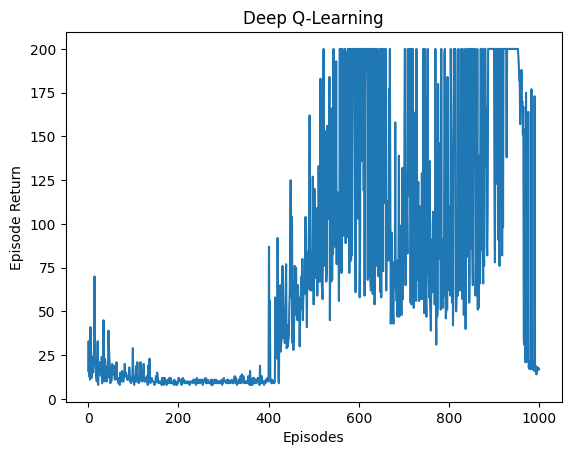

In [82]:
# Jit functions
q_learning_select_action_jit = jax.jit(q_learning_select_action)
q_learn_jit = jax.jit(q_learn)

# Run environment loop
print("Starting training. This may take up to 8 minutes to complete.")
episode_returns, evaluator_returns = run_training_loop(
                                        env_name,
                                        Q_LEARNING_PARAMS,
                                        q_learning_select_action_jit,
                                        Q_LEARNING_ACTOR_STATE,
                                        q_learn_jit,
                                        Q_LEARNING_LEARN_STATE,
                                        Q_LEARNING_MEMORY,
                                        num_episodes=1001,
                                        train_every_timestep=True, # do learning after every timestep
                                        video_subdir="q_learning"
                                    )

plt.plot(episode_returns)
plt.xlabel("Episodes")
plt.ylabel("Episode Return")
plt.title("Deep Q-Learning")
plt.show()

На этом этапе, как мы надеемся, приближенная Q-функция сошлась к приемлемой политике балансировки шеста в задаче CartPole.

In [83]:
#@title Визуализация политики
#@markdown Выберите номер эпизода, кратный 100 и меньший или равный 1000, и **запустите эту ячейку**.
episode_number = 600 #@param {type:"number"}

assert (episode_number % 100) == 0, "Episode number must be a multiple of 100 since we only record every 100th episode."
assert episode_number < 1001, "Episode number must be less than or equal to 1000"


eval_episode_number = int(episode_number / 100 * 8)
video_path = f"./video/q_learning/eval/rl-video-episode-{eval_episode_number}.mp4"

mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Кроме того, существует множество алгоритмов RL, которые вносят существенные улучшения в REINFORCE и Deep Q-Learning. См. эти ресурсы:
* [REINFORCE с базовым уровнем](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#baselines-in-policy-gradients)
* [Double Deep Q-Network](https://arxiv.org/pdf/1509.06461.pdf)
* [Proximal Policy Optimisation (PPO)](https://arxiv.org/pdf/1707.06347.pdf)

Если вы ищете более углубленный онлайн-курс по RL, вы можете ознакомиться с этими курсами:
* [Reinforcement Learning Foundations on LinkedIn Learning](https://www.linkedin.com/learning/reinforcement-learning-foundations) (создано одним из наших собственных преподавателей, Хаулатом Абдулхакимом)
* [Введение в Reinforcement Learning on FreeCodeCamp](https://www.freecodecamp.org/news/an-introduction-to-reinforcement-learning-4339519de419/)
* [Специализация обучения с подкреплением на Coursera](https://www.coursera.org/specializations/reinforcement-learning)

Наконец, самый влиятельный учебник по обучению с подкреплением доступен бесплатно онлайн:
* [Обучение с подкреплением: введение](http://incompleteideas.net/book/the-book-2nd.html) Ричарда С. Саттона и Эндрю Г. Барто


**Ссылки:**

* [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/)
* [Deep Q-Network]()